# Real Time Demand Forecasting Model

In [1]:
#import models needed for machine learning algorhithms
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
# import/load the dataset
file = r'/home/keembo/pacmann_project/notebook/DataCoSupplyChainDataset.csv'
data = pd.read_csv(file, encoding='latin1')

# Display first few rows
data.head()


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [3]:
#check for the datatypes
data_types = data.dtypes

#check for missing values
missing_values = data.isnull().sum()

#show results
print(data_types)
missing_values

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Delivery Status                   object
Late_delivery_risk                 int64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Email                    object
Customer Fname                    object
Customer Id                        int64
Customer Lname                    object
Customer Password                 object
Customer Segment                  object
Customer State                    object
Customer Street                   object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Latitude                         float64
Longitude                        float64
Market          

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


### Data Processing

In [4]:
#Check missing values percentage over total number of rows in the dataframe
missing_values_percentage = (missing_values / data.shape[0]) * 1
#sort missing values percentage in descending order
missing_values_percentage = missing_values_percentage.sort_values(ascending=False)
#filter out 0 percentages
missing_values_percentage = missing_values_percentage[missing_values_percentage!= 0]
missing_values_percentage

Product Description    1.000000
Order Zipcode          0.862397
Customer Lname         0.000044
Customer Zipcode       0.000017
dtype: float64

In [6]:
# Drop the highest percentage of missing values in the dataset.
data_cleaned = data.drop(['Product Description', 'Order Zipcode'], axis=1)

# Impute missing values in undropped collumns with Unknown.
data_cleaned['Customer Lname'].fillna(value='Unknown',inplace=True)
data_cleaned['Customer Zipcode'].fillna(value='Unknown',inplace=True)

# Check the cleaned data results
data_cleaned.isnull().sum()

/tmp/ipykernel_31134/1093585110.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_cleaned['Customer Zipcode'].fillna(value='Unknown',inplace=True)


Type                             0
Days for shipping (real)         0
Days for shipment (scheduled)    0
Benefit per order                0
Sales per customer               0
Delivery Status                  0
Late_delivery_risk               0
Category Id                      0
Category Name                    0
Customer City                    0
Customer Country                 0
Customer Email                   0
Customer Fname                   0
Customer Id                      0
Customer Lname                   0
Customer Password                0
Customer Segment                 0
Customer State                   0
Customer Street                  0
Customer Zipcode                 0
Department Id                    0
Department Name                  0
Latitude                         0
Longitude                        0
Market                           0
Order City                       0
Order Country                    0
Order Customer Id                0
order date (DateOrde

In [7]:
# Create a new dataframe for the transformed data
data_trans = data_cleaned.copy()

# Convert Date into datetime format
data_trans['order date (DateOrders)'] = pd.to_datetime(data_trans['order date (DateOrders)'])
data_trans['shipping date (DateOrders)'] = pd.to_datetime(data_trans['shipping date (DateOrders)'])

# Verify that the OrderID column is of type string
check_data_type = data_trans.dtypes
check_data_type

Type                                     object
Days for shipping (real)                  int64
Days for shipment (scheduled)             int64
Benefit per order                       float64
Sales per customer                      float64
Delivery Status                          object
Late_delivery_risk                        int64
Category Id                               int64
Category Name                            object
Customer City                            object
Customer Country                         object
Customer Email                           object
Customer Fname                           object
Customer Id                               int64
Customer Lname                           object
Customer Password                        object
Customer Segment                         object
Customer State                           object
Customer Street                          object
Customer Zipcode                         object
Department Id                           

### Feature Engineering

In [102]:
# Feature engineering: Extracting date features from the data'

# For order date
data_trans['order_year'] = data_trans['order date (DateOrders)'].dt.year
data_trans['order_month'] = data_trans['order date (DateOrders)'].dt.month

# Display the dataframe with the new features
aggregated_data = data_trans.groupby(['order_year', 'order_month'])['Order Item Quantity'].sum().reset_index()

aggregated_data = aggregated_data[aggregated_data['order_year'] != 2018]

# Create a proper datetime index for the aggregated data
aggregated_data['date'] = pd.to_datetime(aggregated_data['order_year'].astype(str) + '-' + aggregated_data['order_month'].astype(str))

# Sort the data by date to ensure it's in chronological order
aggregated_data = aggregated_data.sort_values('date')



,order_year,order_month,Order Item Quantity,date
0,2015,1,11854,2015-01-01
1,2015,2,10438,2015-02-01
2,2015,3,12062,2015-03-01
3,2015,4,11287,2015-04-01
4,2015,5,11902,2015-05-01
5,2015,6,11203,2015-06-01
6,2015,7,11800,2015-07-01
7,2015,8,11612,2015-08-01
8,2015,9,11366,2015-09-01
9,2015,10,11703,2015-10-01


In [178]:
# The final series for forecasting
y = aggregated_data.set_index('date')['Order Item Quantity']
y

date
2015-01-01    11854
2015-02-01    10438
2015-03-01    12062
2015-04-01    11287
2015-05-01    11902
2015-06-01    11203
2015-07-01    11800
2015-08-01    11612
2015-09-01    11366
2015-10-01    11703
2015-11-01    11463
2015-12-01    11790
2016-01-01    11597
2016-02-01    10765
2016-03-01    11349
2016-04-01    11208
2016-05-01    11603
2016-06-01    11008
2016-07-01    11652
2016-08-01    11683
2016-09-01    11284
2016-10-01    11936
2016-11-01    11493
2016-12-01    11774
2017-01-01    11605
2017-02-01    11070
2017-03-01    11676
2017-04-01    11189
2017-05-01    11033
2017-06-01    10194
2017-07-01    11091
2017-08-01    11095
2017-09-01    10502
2017-10-01     2490
2017-11-01     2055
2017-12-01     2124
Name: Order Item Quantity, dtype: int64

In [131]:
# Determine the split point, usually a percentage of the total data
split_point = int(len(y) * 0.7)  # For instance, 80% for training, 20% for testing

# Split the data
y_train = y[:split_point]
y_test = y[split_point:]


### Time Series Foreacast

In [118]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model with some initial p, d, q values
# Note: You might want to use auto_arima or another method to find optimal parameters
model = ARIMA(y_train, order=(1,0,0))  # Example order, adjust based on your data

# Fit the model
fitted_model = model.fit()

/home/keembo/miniconda3/envs/mlprocess_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/keembo/miniconda3/envs/mlprocess_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/keembo/miniconda3/envs/mlprocess_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [119]:
# Making predictions
predictions = fitted_model.forecast(steps=len(y_test))

# The predictions are for the period in y_test
predictions

2017-05-01    11616.028117
2017-06-01    11411.139283
2017-07-01    11509.445302
2017-08-01    11462.277903
2017-09-01    11484.908903
2017-10-01    11474.050510
2017-11-01    11479.260386
2017-12-01    11476.760678
Freq: MS, Name: predicted_mean, dtype: float64

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate error metrics
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Square Error: {rmse}")

Mean Absolute Error: 3916.2338852007842
Root Mean Square Error: 5701.989005471793


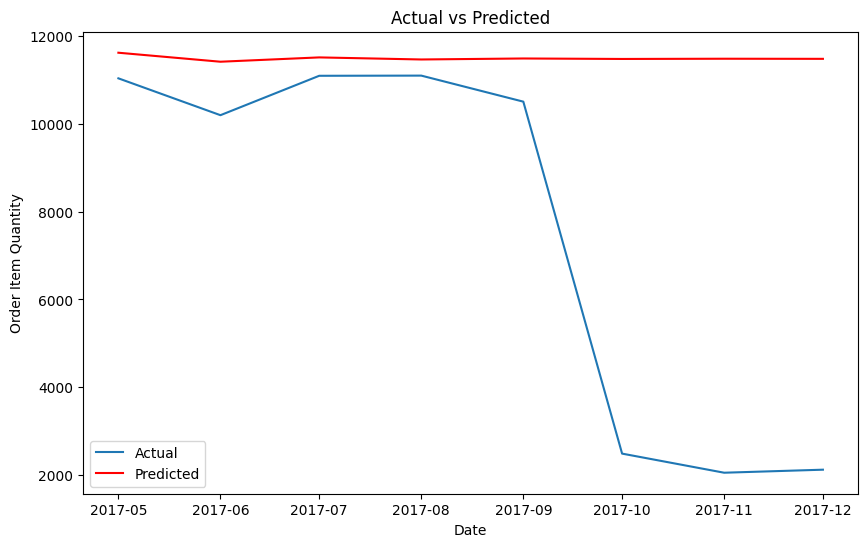

In [121]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Order Item Quantity')
plt.legend()
plt.show()

In [174]:
import statsmodels.api as sm

# Define the SARIMA model
# Let's say your data has a yearly seasonality with monthly data, hence s=12
# The order (p, d, q) and seasonal_order (P, D, Q, s) should be determined based on your specific dataset
sarima_model = sm.tsa.statespace.SARIMAX(y_train,
                                            order=(1, 0, 0),
                                            seasonal_order=(0, 0, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

fitted_model = sarima_model.fit()

print(fitted_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18796D+00    |proj g|=  1.58271D-01

At iterate    5    f=  6.11410D+00    |proj g|=  1.08545D+00

At iterate   10    f=  6.10192D+00    |proj g|=  6.32679D-04

At iterate   15    f=  6.10190D+00    |proj g|=  1.96835D-02

At iterate   20    f=  6.10021D+00    |proj g|=  4.78160D-02

At iterate   25    f=  6.04483D+00    |proj g|=  9.73552D-01

At iterate   30    f=  6.02038D+00    |proj g|=  1.30341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/keembo/miniconda3/envs/mlprocess_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/keembo/miniconda3/envs/mlprocess_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [175]:
# Make predictions for the same interval as y_test
start = len(y_train)
end = start + len(y_test) - 1  # -1 because Python is zero-indexed

# Generate predictions
predictions = fitted_model.predict(start=start, end=end, dynamic=True)
predictions

2017-02-01    11496.021887
2017-03-01    11521.491429
2017-04-01    11452.357797
2017-05-01    11461.211630
2017-06-01    11439.821356
2017-07-01    11418.471002
2017-08-01    11397.160496
2017-09-01    11375.889761
2017-10-01    11354.658724
2017-11-01    11333.467312
2017-12-01    11312.315449
Freq: MS, Name: predicted_mean, dtype: float64

In [176]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate error metrics
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Square Error: {rmse}')

Mean Absolute Error: 2850.2621803563056
Root Mean Square Error: 4787.005642141713


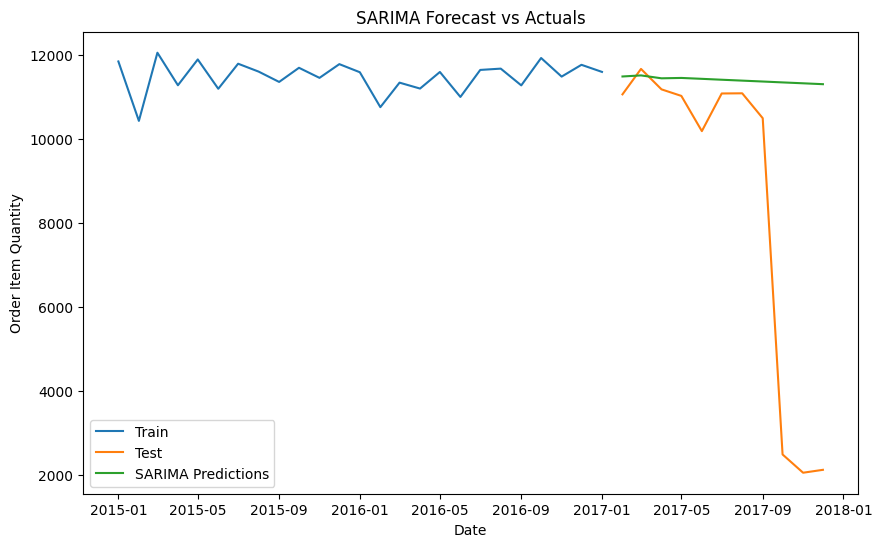

In [177]:
import matplotlib.pyplot as plt

# Plot the predictions along with the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, predictions, label='SARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Order Item Quantity')
plt.title('SARIMA Forecast vs Actuals')
plt.legend()
plt.show()


### Test Predictions

In [184]:
model = fitted_model

def input_data(month, year):
    input_data = pd.DataFrame(
        {
            'order_year': [year],
            'order_month': [month]
        }
    )
    input_data = pd.DataFrame(input_data, columns=['order_year', 'order_month'])
    return input_data

def make_predictions(model, new_month, new_year):
    input_data_time = pd.to_datetime(f"{new_year}-{new_month}-01") 
    months_ahead = (input_data_time.year - 2017) * 12 + input_data_time.month - 12
    
    start = len(model.model.endog)
    end = start + months_ahead - 1
    
    predictions = model.predict(start=start, end=end, dynamic=False)
    predictions = predictions.iloc[-1]
    return predictions

# Input
new_month, new_year = 5,2022
input_features = input_data(new_month, new_year)
forecasted_quantity = make_predictions(model, new_month, new_year)
print("Forecasted Quantity for", new_month, "/", new_year, ":", forecasted_quantity)

Forecasted Quantity for 5 / 2022 : 10458.69164619008


In [181]:
from pmdarima.arima import auto_arima

# Assuming y_train is your training time series
auto_model = auto_arima(y_train, 
                        start_p=0, start_q=0,  # Initial guess for p, q
                        max_p=3, max_q=3,      # Maximum p, q
                        seasonal=True, m=6,        # Change to True if your data is seasonal
                        start_P=0, start_Q=0, max_P=2, max_Q=2,
                        information_criterion='aic',
                        trace=True,            # Print the fitting process
                        error_action='ignore', # Don't want to know if an order does not work
                        suppress_warnings=True,# Suppress warnings
                        stepwise=True)         # Stepwise search to find the best model

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=370.465, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=367.938, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=368.593, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=540.467, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=366.673, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[6] intercept   : AIC=366.854, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=368.853, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[6] intercept   : AIC=369.284, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[6] intercept   : AIC=369.258, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[6] intercept   : AIC=368.514, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[6] intercept   : AIC=370.828, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[6]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[6] intercept
Total fit time: 0.863 seconds
                               SARIMAX Results                                
Dep. Variable:           